In [1]:
from utils.experiment_utils import get_all_experiments_info, load_best_model
import torch
import os
import hydra
from omegaconf import DictConfig, OmegaConf

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from notebooks.mnist_classifier.mnist_tiny_cnn import TinyCNN

from mixer.mixer import SetMixer
from datasets.mnist import MNISTDataset

from torch.utils.data import DataLoader
from itertools import product

from scipy.linalg import sqrtm
import ternary

In [2]:
def w2_multinom_pairwise(ps):
    # build pop cov matrix
    def pop_cov(x):
        n = len(x)
        c = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                c[i, j] = x[i]*(1 - x[i]) if i == j else -x[i]*x[j]
        return c

    ps = np.array(ps)
    n = len(ps)
    dists = np.zeros((n, n))

    sigs = [pop_cov(p) for p in ps]
    roots = [sqrtm(s) for s in sigs]

    for i in range(n):
        for j in range(n):
            mu_diff = np.sum((ps[i] - ps[j])**2)
            mid = sqrtm(roots[i] @ sigs[j] @ roots[i])
            if np.iscomplexobj(mid):
                mid = mid.real
            cov_diff = np.trace(sigs[i] + sigs[j] - 2*mid)
            dists[i, j] = np.sqrt(mu_diff + cov_diff)

    return dists


def plot_ternary(ax, dists, mix_probs, title=None, scale=99):

    prob_tuples = [tuple(map(int, np.round(s * scale))) for s in mix_probs]
    anchor_idx = prob_tuples.index((scale//3, scale//3, scale//3))
    # anchor_idx = 0
    colors = dists[anchor_idx]/np.nan_to_num(dists[anchor_idx]).max()
    simplex_d = {prob_tuples[i]: colors[i] for i in range(len(prob_tuples))}

    tax = ternary.TernaryAxesSubplot(ax=ax, scale=scale)
    tax.heatmap(simplex_d, style="h", colorbar=False)
    tax.boundary()
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    if title:
        tax.set_title(title)

    # tax.scatter([prob_tuples[anchor_idx]], marker='*', color='pink', s=100, zorder=10)

In [3]:
def simplex_grid(dim, points_per_dim):
    lin = np.linspace(0, 1, points_per_dim)
    grid = np.array(list(product(*([lin] * dim))))
    grid = grid[np.isclose(grid.sum(axis=1), 1)]  # keep only rows that sum to 1
    return grid

points_per_dim = 10
k = 3
set_size = 1000

mix_probs_labels = simplex_grid(k, points_per_dim)

w = w2_multinom_pairwise(mix_probs_labels)
dna = np.load('numerical_results/dna_multinomial_hyena_dists.npy')
mnist = np.load('numerical_results/mnist_multinomial_ConvDistributionEncoder_dists.npy')
plain = np.load('numerical_results/plain_multinomial_DistributionEncoderGNN_dists.npy')

/tmp/ipykernel_745830/175093146.py:25: RuntimeWarning: invalid value encountered in sqrt
  dists[i, j] = np.sqrt(mu_diff + cov_diff)


/tmp/ipykernel_745830/1535724830.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


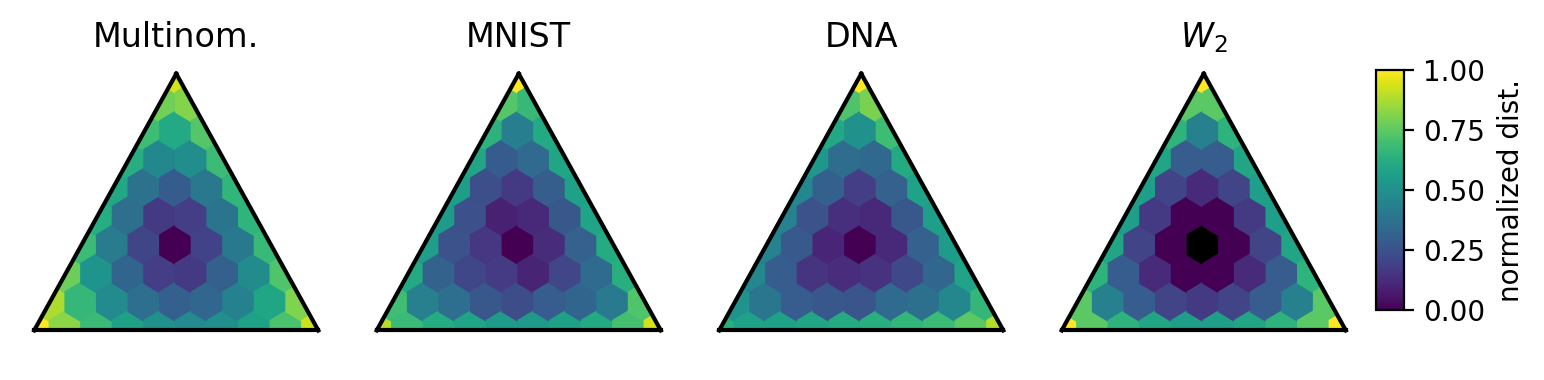

In [4]:

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

fig, axs = plt.subplots(1, 4, figsize=(7, 2), dpi=200)  # 1 row, 4 plots :)

norm = Normalize(vmin=0, vmax=1)
cmap = plt.get_cmap('viridis')  # or any other!

# plot them in order: w, plain, mnist, dna
plot_ternary(axs[3], w, mix_probs_labels, scale=9, title=r'$W_2$')
plot_ternary(axs[0], plain, mix_probs_labels, scale=9, title='Multinom.')
plot_ternary(axs[1], mnist, mix_probs_labels, scale=9, title='MNIST')
plot_ternary(axs[2], dna, mix_probs_labels, scale=9, title='DNA')

plt.subplots_adjust(right=0.96)

# add vertical colorbar in the freed-up space
sm = ScalarMappable(norm=norm, cmap=cmap)
cbar_ax = fig.add_axes([0.99, 0.2, 0.02, 0.6])  # [left, bottom, width, height]
fig.colorbar(sm, cax=cbar_ax, label='normalized dist.')

plt.tight_layout()
plt.show()